# INFO-F-422 - Statistical Foundations of Machine Learning 

### Pascal Tribel - [pascal.tribel@ulb.be](mailto:pascal.tribel@ulb.be)
### Cédric Simar - [cedric.simar@ulb.be](mailto:cedric.simar@ulb.be)
### Gian Marco Paldino - [gian.marco.paldino@ulb.be](mailto:gian.marco.paldino@ulb.be)

## TP 6 - Classification

### Introduction
In classification problem, the target is a category (a discrete variable) and its conditional distribution is 
$$P({\mathbf y}|x)$$
where:
- $\mathbf{y} \in \{ C_1,\dots, C_K\}$ represents the output variable (also called target)
- $x \in \mathbb{R}^n$ represents the vector of inputs (also called features)

In classification, the goal of learning is to return an estimator 
$$h(x,\alpha)$$
of the conditional probabiity $P({\mathbf y}|x)$, where $\alpha$ denotes the set of parameters of the model $h$. 

The learning of the estimator is done  on the basis of an available input/output
training set $D_N$ made of $N$ observation pairs $(x_i,y_i)$ where $x_i \in \mathbb{R}^n$. 

### Data generation
As seen in the theoretical course, there are multiple ways to generate datasets for binary classification problems.
#### Generative way:
First, generate the class $y_i \in \{0, 1\}$, $i \in \{1,...,N\}$, using the _a priori_ probability, then generate the $x$ values, given the **class conditional density $p(x | \mathbf{y}=y_i)$**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

If we name the _a priori_ probability $p_1 = P(\mathbf{y} = 1)$, we can generate the $Y$ dataset:

In [2]:
N = 500
n = 2
p1 = 0.4

Y = np.random.choice([0, 1], size=N, p=[1-p1, p1])

Then, we can generate the $x$ data, following two multivariate normal distribution (recall practical 1). We define two distributions, for each of the two classes. Then, depending on the $y$ class of each item, we sample the corresponding multivariate normal distribution. 

Here, to make sure that `cov0` and `cov1` are defined positive, we generate a random $A$ matrix, then `cov` is computed as $A^TA$.

In [3]:
A0 = np.random.rand(n, n)
cov0 = A0.T @ A0
mu0 = np.random.normal(loc=2, size=n)

A1 = np.random.rand(n, n)
cov1 = A1.T @ A1
mu1 = np.random.normal(size=n)

In [4]:
X = np.zeros((N, n))
for i in np.arange(N):
    if Y[i] == 1:
        X[i, :] = np.random.multivariate_normal(mu1, cov1, size=1)
    else:
        X[i, :] = np.random.multivariate_normal(mu0, cov0, size=1)

Then, we plot the generated data. 

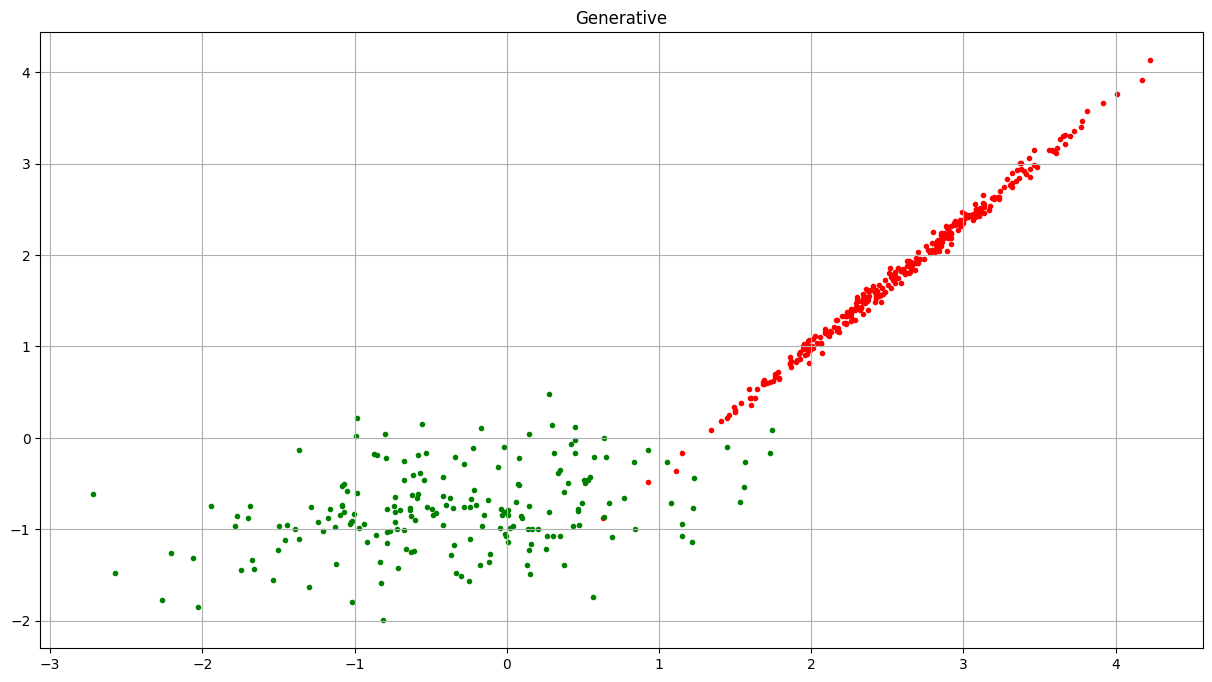

In [5]:
I0 = np.where(Y==0)
I1=np.where(Y==1)

plt.figure(figsize=(15, 8))
plt.scatter(X[I0, 0], X[I0, 1], marker='.', color="red")
plt.scatter(X[I1, 0], X[I1, 1], marker='.', color="green")
plt.grid()
plt.title("Generative")
plt.show()

#### Discriminative way
Otherwise, if we have the conditional distributions $P(y|x)$, we can first sample $x$, then determine the class $y$.

In [6]:
from scipy.stats import multivariate_normal

In [7]:
def condprob(x, cov1, mu1, cov0, mu0, p1):
    return multivariate_normal.pdf(x, mean=mu1, cov=cov1)*p1/(multivariate_normal.pdf(x, mean=mu1, cov=cov1)*p1+multivariate_normal.pdf(x, mean=mu0, cov=cov0)*(1-p1))

First, we sample $x$ according to the probability density function:
$$p(x)= p_1*p(x|y=1) + (1-p_1)*p(x|y=0)$$

Those are mixture of gaussians (recall: practical 1).

In [8]:
X = np.zeros((N,n))
for i in np.arange(N):
    if np.random.uniform()<p1:
        X[i,:] = np.random.multivariate_normal(mu1, cov1, size=1)
    else:
       X[i,:] = np.random.multivariate_normal(mu0, cov0, size=1)  

Then, using the Bayes theorem, we compute the $y$ classes.

Recall the Bayes theorem
$$P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}$$
In order to compute the term $P(X|Y)$, we need to make an hypothesis on the distribution of $X$ according to $Y$. Here, we make the hypothesis of gaussianity (how could we test if this is valid ?), which allows us to use the `pdf` function from the `multivariate_normal` library already presented. However, in practice, the $\mu$ and `cov` should be estimated from the data.

In [9]:
Y = np.zeros((N, 1))
for i in np.arange(N):
    p1i = condprob(X[i, :], cov1, mu1, cov0, mu0, p1)
    Y[i] = np.random.choice([0, 1], size=1, p=[1-p1i, p1i])

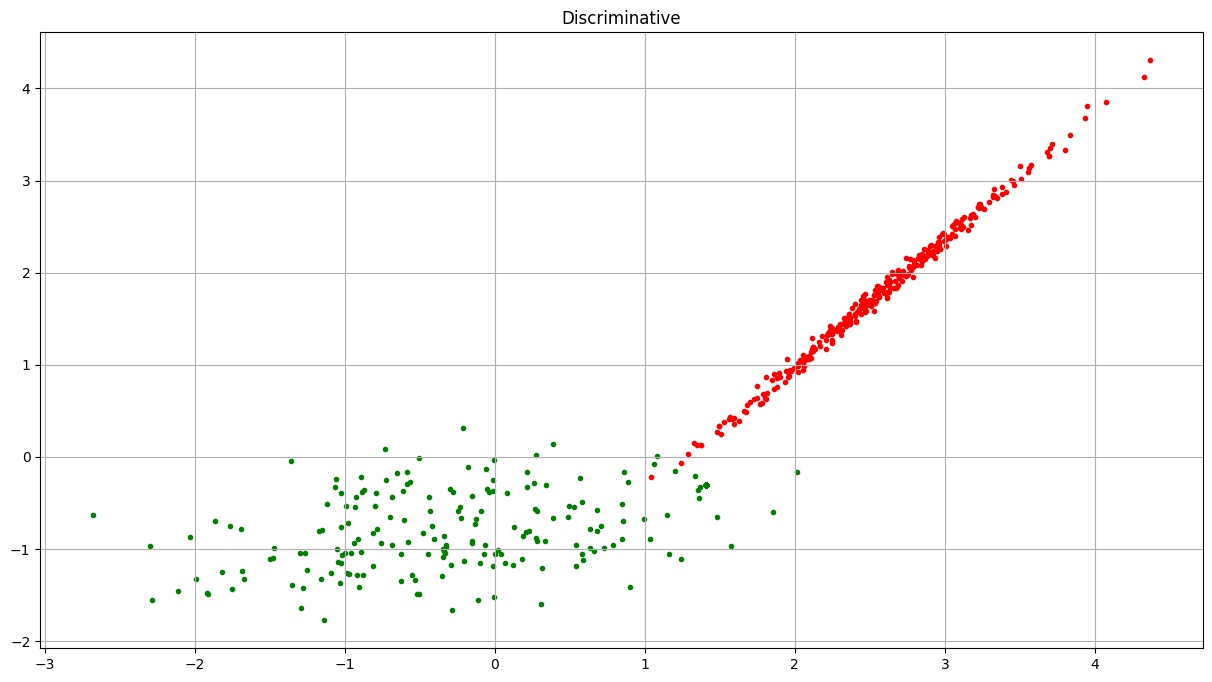

In [10]:
I0 = np.where(Y==0)
I1 = np.where(Y==1)

plt.figure(figsize=(15, 8))
plt.scatter(X[I0, 0], X[I0, 1], marker='.', color="red")
plt.scatter(X[I1, 0], X[I1, 1],marker='.', color="green")
plt.grid()
plt.title("Discriminative")
plt.show()

Of course, the computed datasets are equivalent, no matter the method used.

### Exercises
* For the lastly generated sets $X, Y$, given three points $q=\{(0, 0), (3, 3), (0, 2)\}$, compute $P(\mathbf{y}| x=q)$ for each class $y$.
* Can you adapt the two procedures to get more-dimensional data (i.e. $x$ is not in $\mathbb{R}^2$ but in $\mathbb{R}^n$) ?
* Can you adapt the two procedures to get more-classes data (i.e. $y$ is not in $\{0, 1\}$ but in $\{0,...,k\}$) ?

### Metrics and model evaluations methods
In the previous practicals, when we were dealing with regression tasks, we defined different metrics for evaluating the quality of some model's predictions. Remind: we defined the Mean Squared Error, then, we normalized it to define the Normalized Mean Squared Error. We spoke about other metrics, such as the MAE. All those quantities, while highly informative when applied to continuous quantities, are not as useful when dealing with classes.

Let us consider a practical example. You are assigned the task to determine if some rocket components are working (1) or not (0). In this task, it seems clear that the fact of assigning _working_ to a _non-working_ piece is worse than assigning _non-working_ to a _working_ piece (you could lose astronauts). However, this is not reflected by the MSE: in both cases, assigning the wrong label would lead to an error of $1$. 

In binary classification, however, we can determine entirely the cases possible after prediction:
* Expected: 0, Predicted: 0 -> True Negative (TN)
* Expected: 1, Predicted: 1 -> True Positive (TP)
* Expected: 0, Predicted: 1 -> False Positive (FP)
* Expected: 1, Predicted: 0 -> False Negative (FN)

In this terminology, it is clear that the previous example suffers more from the False Positives than the False Negatives.

We can present those quantities in a matrix, called the *confusion matrix*:

| |Negative|Positive|
|-|-|-|
|Classified as negative|TN|FN|
|Classified as positive|FP|TP|

In `sklearn`, the function `confusion_matrix` builds it from the set of expected and predicted labels. This, however, is not so-to-say a scoring method. There are different values, derived from the confusion matrix quantities, that allows to score a given prediction set:
* The **precision**: $\frac{\text{TP}}{\text{TP}+\text{FP}}$
* The **recall**: $\frac{\text{TP}}{\text{TP}+\text{FN}}$
* The **F1 score**: $\frac{2\text{TP}}{2\text{TP}+\text{FP}+\text{FN}}$ which is the harmonic mean between the precision and the recall scores
* More generally, the **F Beta score**:  $\frac{(1+\beta^2)\text{TP}}{(1+\beta^2)\text{TP}+\text{FP}+\beta^2\text{FN}}$

However, those quantities often do not take into account the number of True Negatives. Note: most of those scoring methods are implemented in `sklearn`.

### Bayes classifier
Remind: the Bayes theorem states that
$$P(y|x) = \frac{P(x|y)P(y)}{P(x)}$$

and this can be used as a classifier. More specifically, for continuous inputs, we have
$$P(y=c_k|x=x) = \frac{p_x(x|y=c_k)P(y=c_k)}{\sum_{k=1}^K p_x(x|y=c_k)P(y=c_k)}$$

Note, it requires to know what is the density function $p_x$. If we make the hypothesis that those follow a normal distribution, we can use the `GaussianNB` class from `sklearn`.

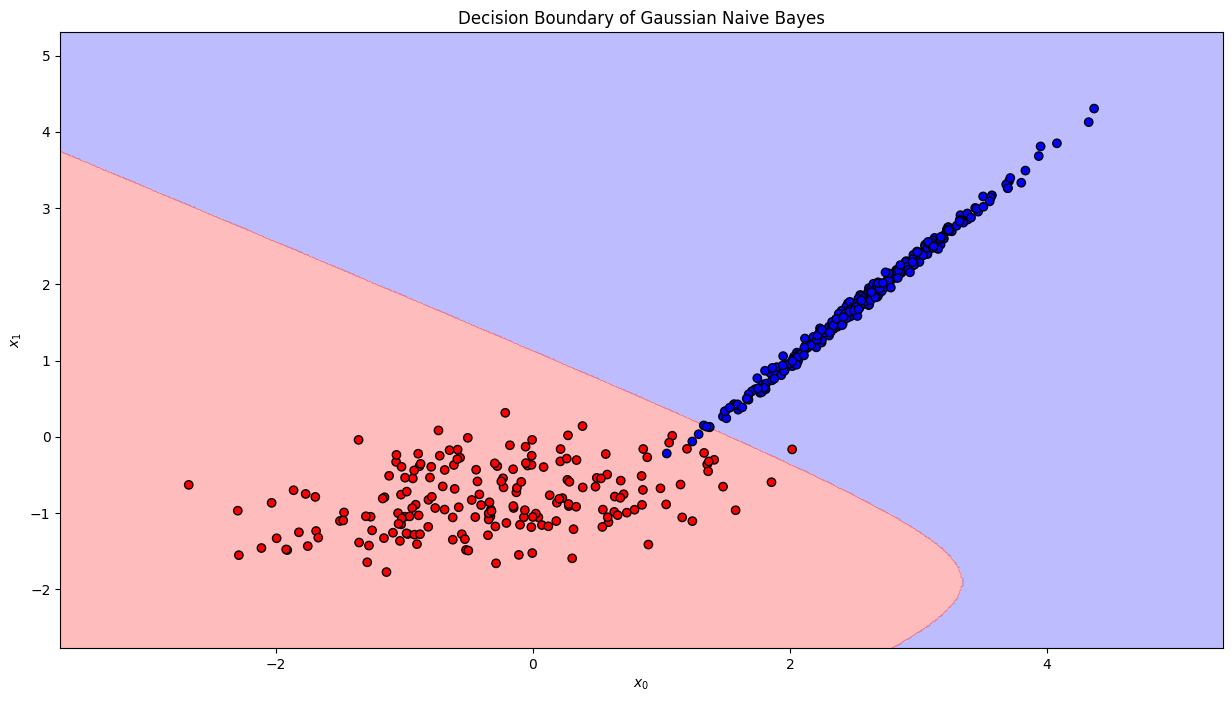

In [11]:
from sklearn.naive_bayes import GaussianNB

def plot_field(X, Y, model, name=""):
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.linspace(x0_min, x0_max, 1000),
                           np.linspace(x1_min, x1_max, 1000))
    
    Z = model.predict(np.c_[xx0.ravel(), xx1.ravel()]).reshape(xx0.shape)
    
    plt.figure(figsize=(15, 8))
    plt.contourf(xx0, xx1, Z, alpha=0.3, cmap=plt.cm.bwr)
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.bwr)
    
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.title(f"Decision Boundary of {name}")
    plt.show()
    
model = GaussianNB().fit(X, Y.ravel())

plot_field(X, Y, model, "Gaussian Naive Bayes")

However, when the cost associated with False Negatives and False Positive are not equal, the computation cannot be used as is. Let us define two costs: $C_{FP}$ and $C_{FN}$. Keep in mind, here, that we consider the two other costs $C_{TP}, C_{TN} = 0$. The expected cost for each possible decision is $C(1|x) = P(y=0|x)C_{FP}$ and $C(0|x) = P(y=1|x)C_{FN}$. The two _a posteriori_ probabilities $P(y|x)$ can be estimated from the data. Let us call $p_1 = P(y=1|x)$. Now, given those, for a sample $x$, we want to assign the class that minimizes the expected cost. We predict $Y=1$ if $C(1|x)<C(0|x)$, or $(1-p_1)C_{FP} < p_1 C_{FN}$. We can rewrite this as
$$p_1 > \frac{C_{FN}}{C_{FP}+C_{FN}}$$

* If $C_{FP} = C_{FN}$, then $\frac{C_{FN}}{C_{FP}+C_{FN}} = \frac12$. This is the classic case, where we output the maximum a posteriori class.
* If $C_{FP} > C_{FN}$, then it is better to output $y=1$, this reduces the number of FP.
* Otherwise, it is better to output $y=0$.

#### Exercise
* In the generated data, suppose that having a FN has a cost of $1$ while having a FP has a costof $0.2$. What is the threshold and the optimal class ?

### Linear model for classification
As it has been done for the regression tasks, we can use a linear model for classifying the previously generated points. As an example, in `sklearn`, we can use the `LogisticRegression` class:

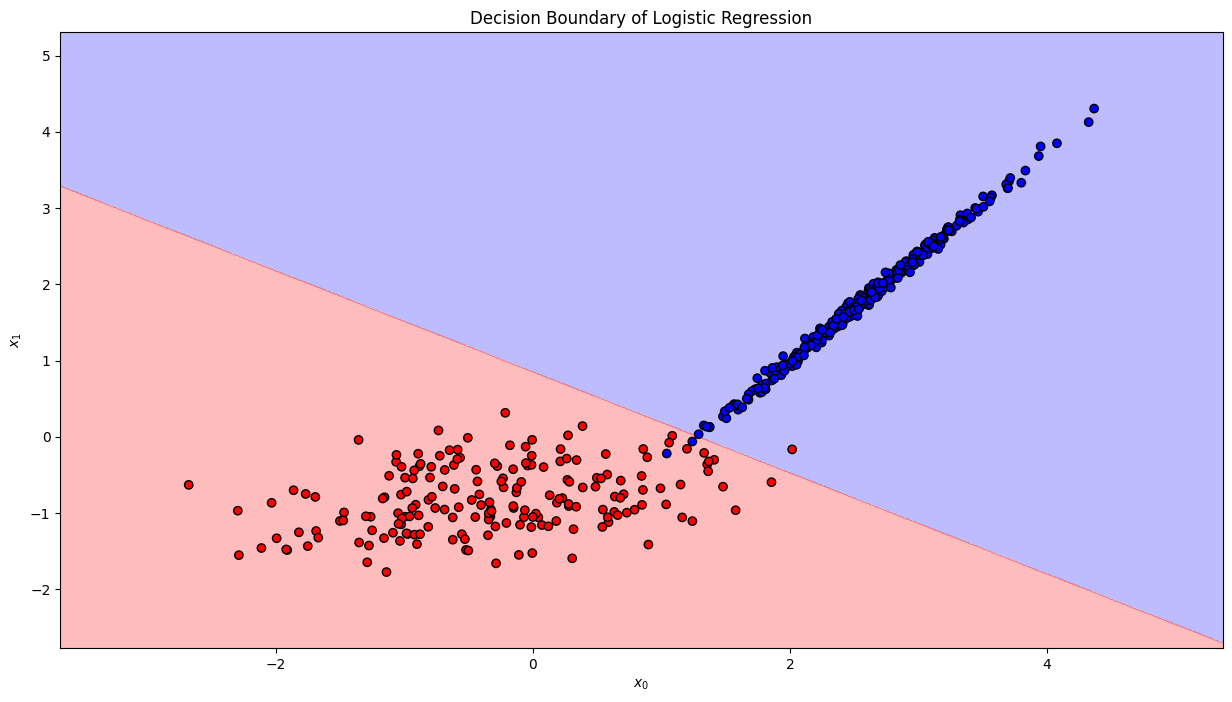

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X, Y.ravel())

plot_field(X, Y, model, "Logistic Regression")

Now, for fun, we can train another model to see how the space is then divided: 

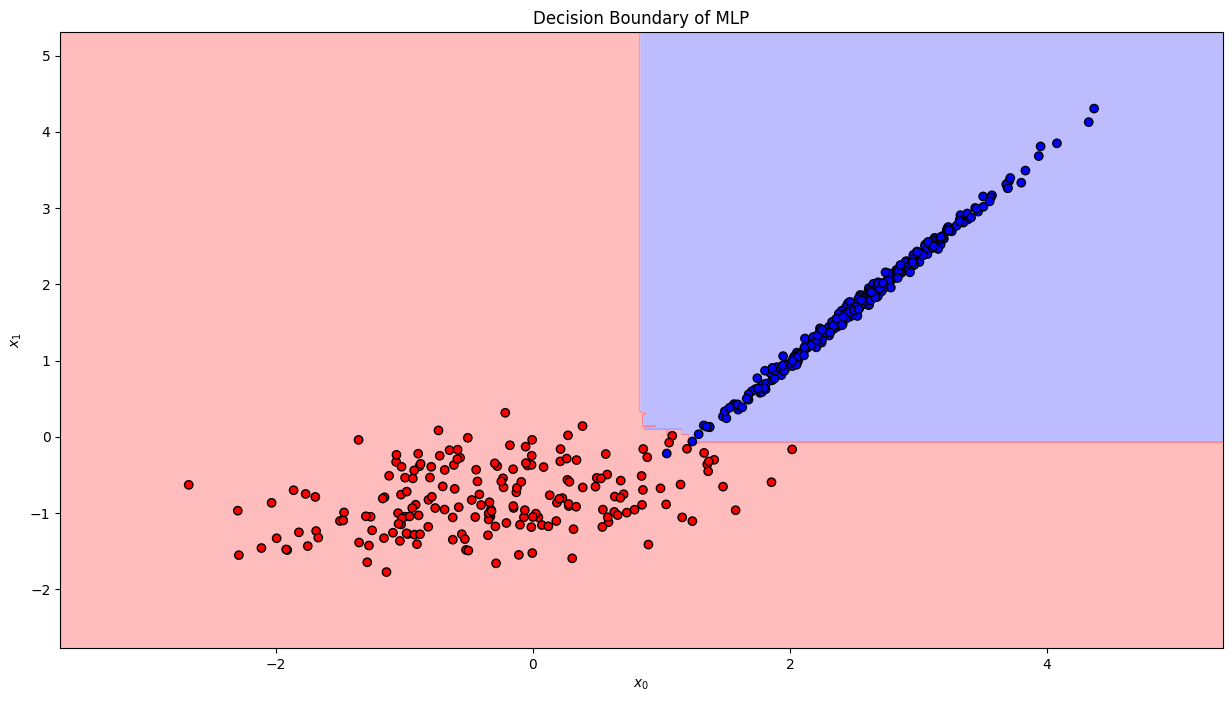

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier().fit(X, Y.ravel())

plot_field(X, Y, model, "MLP")

#### Exercise: polynomial features
* Extend the dataset by adding polynomial features (e.g., degree 2)
* Train a logistic regression model on both the original and extended datasets.
* Compare decision boundaries and discuss the effect of feature engineering (note: see previous practicals for hint).

#### Exercise: KNN
* Implement a KNN classifier (`sklearn.neighbors.KNeighborsClassifier`).
* Vary $k$ (e.g., 1, 5, 20) and visualize decision boundaries.
* Discuss underfitting/overfitting trade-offs.

#### Exercise: Bayes
* Compute the true Bayes decision boundary using the known densities $p(x|y)$.
* Compare it to the decision boundaries of logistic regression and KNN.
* Discuss the optimality of Bayes classification.

#### Exercise: Other models
* Use other models to classify $X$ and $Y$ and show their decision boundaries.
* Compare their performances using the different metrics.

#### Exercise: Active learning

* Train a logistic regression classifier on only 20% of the dataset.
* Select new points to label based on model uncertainty (e.g., samples near decision boundary).
* Retrain and measure accuracy gain.
* Discuss the benefits of active learning in data labeling.

#### Exercise: More classes
* Generate a dataset with two features $x_1$, $x_2$, with classes in $\{0, 1, 2, 3\}$.
* Use a Logisitc Regression model to classify the points.
* Use a RandomForestClassifier and a MLPClassifier to classify the points.
* For the three models, show the confusion matrix.
* Using the same visualization function as before, show the decision boundaries of the three models: how are those boundaries related to the way those models work?

### ROC curve
Let us define two important notions:
* The **sensibility**: $\frac{\text{TP}}{\text{TP}+\text{FN}}$. On all the indeed positive cases, what is the portion of correctly assigned positive?
* The **specificity**: $\frac{\text{TN}}{\text{TN}+\text{FP}}$. On all the indeed negative cases, what is the portion of correctly assigned negative?

The _anti-_ versions of both are given by $1 - x$ for each. Now, let us use a threshold model. That is, for a given threshold, if the sample is below, classify it as 0, otherwise classify it as 1. For multiple values of this threshold, the **ROC** curve (for _receiver operating characteristic_) is a plot in which the antispecificity is put in absisse, and the sensibility in ordinate. The **precision/recall** plot displays the precision vs. the recall. Finally, the **lift** curve shows the proportion of _assigned positives_ among all the points (the _alert_ level).

Now, given a specific model, how can we get this _threshold_ ? If we focus on the case of KNN:

When calling `predict_proba(X_test)`, KNN returns tThe proportion of the k nearest neighbors that belong to each class.
For example, with $k=5$, if out of the 5 nearest neighbors, 3 are positive and 2 are negative, then `predict_proba(X)` = (negative class: 2/5, positive class: 3/5).
The positive class score is $0.6$. this is equivalent to the threshold in the previous example.

We can generate a new synthetic dataset in `sklearn`:

In [18]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=2000, n_features=5, n_classes=2,  n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

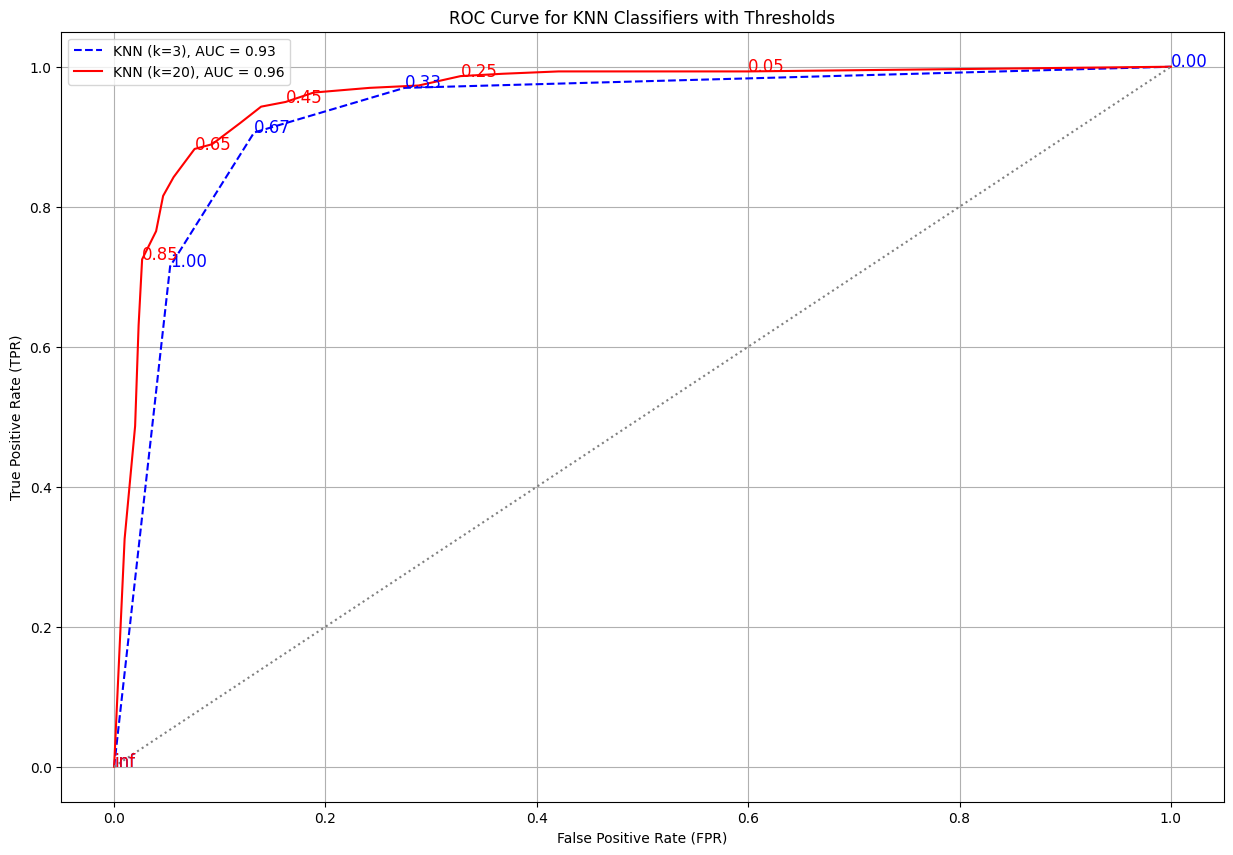

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

knn3 = KNeighborsClassifier(n_neighbors=3)
knn20 = KNeighborsClassifier(n_neighbors=20)
knn3.fit(X_train, y_train)
knn20.fit(X_train, y_train)

y_scores3 = knn3.predict_proba(X_test)[:, 1]
y_scores20 = knn20.predict_proba(X_test)[:, 1]

fpr3, tpr3, thresholds3 = roc_curve(y_test, y_scores3)
fpr20, tpr20, thresholds20 = roc_curve(y_test, y_scores20)
auc3 = auc(fpr3, tpr3)
auc20 = auc(fpr20, tpr20)

plt.figure(figsize=(15, 10))
plt.plot(fpr3, tpr3, label=f'KNN (k=3), AUC = {auc3:.2f}', linestyle='--', color='blue')
plt.plot(fpr20, tpr20, label=f'KNN (k=20), AUC = {auc20:.2f}', linestyle='-', color='red')
plt.plot([0, 1], [0, 1], color='grey', linestyle='dotted')

for i in range(0, len(thresholds3), len(thresholds3)//5):
    plt.text(fpr3[i], tpr3[i], f'{thresholds3[i]:.2f}', fontsize=12, color='blue')
for i in range(0, len(thresholds20), len(thresholds20)//5):
    plt.text(fpr20[i], tpr20[i], f'{thresholds20[i]:.2f}', fontsize=12, color='red')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for KNN Classifiers with Thresholds')
plt.legend()
plt.grid()
plt.show()

### General questions to build a Machine Learning pipeline
In practice, we have seen all the necessary steps to study a given Machine Learning task.
* Is it a classification/regression task ?
    * If it is a classification task: how many classes are there ?
    * If it is a regression task: can we normalize the output ?
* How many input features are there ?
* Can we normalize them ?
* How can we select the useful ones/discard the useless ones ?
* Can we transform the categorical input variables to another encoding ?
* What is the size of the input data (row/columns) ?
* What are the main characteristics of the inputs/outputs ? Is there correlation, redundancy ?
* What does the data look like when plotted ? What is the best way to plot it ?
* What are the best performance metrics for the problem ?
* How can we assess the quality of a given model ?
* Which model is the more justifiable/performant for the problem ?
* How can we assess the generalization capacity of our model ?
* What hypotheses do we do on the problem when using a specific model ?
* Is there something simpler that we can do ?
* ...